### A test of nibabel to load nii DCE-MRI data into dataset

In [15]:
# Select the image to downsample (e.g., imgs[0])

zoom_factors = (0.4, 0.4, 0.4)
timeindex = list(range(9, 27))  # 4,5,...35, total 32 time points

# Test data will create a sphere around the center and do forward step according to advect-diffuse model
# now only save path is required
is_test_data = True

data_template = "data/KX078_DCE_nii_data/psnrT1_FLASH_3D_{:04d}.nii"
mask_path = "data/KX078_DCE_nii_data/Template_C57Bl6_n30_brain_KX_078.nii"
mask_erosion_iter = 10 # if affect mask outside of 
# save_path = "data/KX078_DCE_nii_data/dataset_downsampled.npz"
save_path = "data/test_nii_data/dataset_downsampled.npz"

In [16]:
import numpy as np
import nibabel as nib
# 3D erose and smooth the mask 
from scipy.ndimage import binary_erosion,label,gaussian_filter
# downsample images for quick testing 
from scipy.ndimage import zoom
from utils.visualize import draw_nifti_slices_with_threshold,draw_nifti_slices_with_time
import os

%matplotlib widget
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def read_nii_list(template, data_index):
    datapaths = [template.format(i) for i in data_index]
    imgs = [nib.load(path) for path in datapaths]

    # check whether all headers are align (affine + pixdim)
    ref_header = imgs[0].header
    for img in imgs[0:]:
        assert img.get_data_dtype() == np.dtype('float32')
        assert np.allclose(img.header.get_best_affine(), ref_header.get_best_affine())
        assert np.allclose(img.header['pixdim'], ref_header['pixdim'])
    pixdim = np.round(ref_header['pixdim'][1:4], 4)
    print("All headers are aligned, pixdim: ", ref_header['pixdim'][1:4])
    # directly transfer all to numpy array, shape: (nx, ny, nz, nt)
    imgs = [np.nan_to_num( \
        np.asanyarray(img.dataobj, dtype=np.float32),nan=0.0) for img in imgs]
    imgs = np.stack(imgs, axis=-1)
    return imgs, pixdim


In [18]:
# WARNING: time stamp is related to the actual acquisition time, should record them as part of metadata.
timestamp = [(t - 4) * 4 for t in timeindex]  # in minutes, 4th minute is the injection time, then record MRI every 4 minutes

if is_test_data:
    from utils.forward_sim import generate_block_concentration, generate_swirl_velocity_field, generate_constant_velocity_field, advect_diffuse_forward_simulation 
    domain_shape = (100,100,100)
    pixdim = (0.125, 0.125, 0.125)  # in mm
    D_coeff = 2e-3  # in mm^2/min, WARNING: later if D is not learnable, please set ground truth D in the model config as well
    noise_level_init = 2.0
    noise_level_obs = 5.0
    init_volume = generate_block_concentration(*domain_shape, noise_level=noise_level_init)
    # vx,vy,vz = generate_swirl_velocity_field(*domain_shape, pixdim[0], v0=0.01)
    vx,vy,vz = generate_constant_velocity_field(
        *domain_shape, pixdim[0], v_cell_val=(0.15, 0.15, 0.0)
    )
    total_step = 200
    imgs = advect_diffuse_forward_simulation(init_volume, vx, vy, vz, D_coeff, timestamp[-1], num_steps=total_step, voxel_dims=pixdim)
    # still only select the timestamps we defined
    imgs = np.array(imgs,dtype=np.float32)[(np.array(timestamp)/timestamp[-1] * total_step).astype(int)]
    # reshape imgs to (nx, ny, nz, nt)
    imgs = np.transpose(imgs, (1,2,3,0))
    # after simulation, add noise to all time frames
    imgs += np.random.normal(0, noise_level_obs, imgs.shape)
    mask = np.ones(domain_shape, dtype=bool)
else:
    imgs, pixdim = read_nii_list(data_template, timeindex)
    imgs[imgs < 0] = 0

    print(imgs.shape, pixdim)  # (nx, ny, nz, nt), (dx, dy, dz)
    print(imgs[:,:,:,0].min(), imgs[:,:,:,0].max())

    mask = nib.load(mask_path)
    mask = np.asanyarray(mask.dataobj, dtype=bool)

Running PyTorch simulation on cuda for 88s in 200 steps (dt=0.440s)
Simulation complete.


In [19]:
postmask = binary_erosion(mask, iterations=mask_erosion_iter)

# then isolate the largest connected component
isolated_mask = np.zeros_like(postmask)
labeled_array, num_features = label(postmask)
print("Number of connected components:", num_features)
if num_features > 0:
    largest_component = np.argmax(np.bincount(labeled_array.flat)[1:]) + 1
    isolated_mask[labeled_array == largest_component] = 1

# 3D Gaussian smoothing
smoothed_mask = gaussian_filter(isolated_mask.astype(float), sigma=1) > 0.5
postmask = smoothed_mask.astype(bool)

Number of connected components: 1


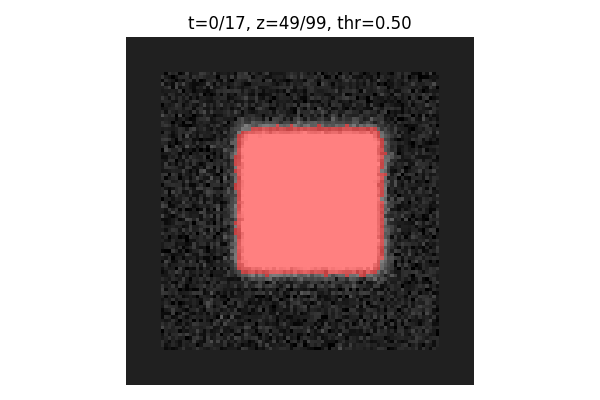

In [20]:
_ = draw_nifti_slices_with_time(imgs, brain_mask=postmask, percentiles=(1,98), slice_along_axis='z')

(40, 40, 40, 18) -0.0 116.03127


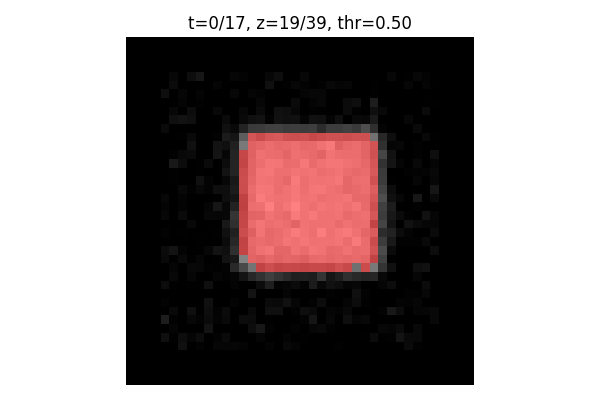

In [21]:

pixdim = pixdim / np.array(zoom_factors)

# zoom and masked (optionally threshold) each image in the 4D array
zoom_factors_4d = (*zoom_factors, 1)

downsampled_mask = zoom(postmask.astype(float), zoom_factors, order=1) > 0.5 # Use linear for masks

down_imgs = zoom(imgs, zoom_factors_4d, order=3)
down_imgs *= downsampled_mask[..., np.newaxis]  # apply mask

down_imgs[down_imgs < 0] = 0

# Print the new shape
print(down_imgs.shape, down_imgs.min(), down_imgs.max())
_ = draw_nifti_slices_with_time(down_imgs, percentiles=(0,100))


In [22]:
# prepare x, which is from pixdim per voxel
x = np.arange(0, down_imgs.shape[0]) * pixdim[0]
y = np.arange(0, down_imgs.shape[1]) * pixdim[1]
z = np.arange(0, down_imgs.shape[2]) * pixdim[2]
print(x.shape, y.shape, z.shape, pixdim)

os.makedirs(os.path.dirname(save_path), exist_ok=True)
# Save the downsampled volume (masked + optionally thresholded) as npz,
# ready to be used in PINN training
np.savez_compressed(save_path,
                    data=down_imgs.astype(np.float32),
                    mask=downsampled_mask.astype(np.bool_),
                    pixdim=pixdim.astype(np.float32),
                    x=x.astype(np.float32),
                    y=y.astype(np.float32),
                    z=z.astype(np.float32),
                    t=np.array(timestamp, dtype=np.float32),)

(40,) (40,) (40,) [0.3125 0.3125 0.3125]
